In [1]:

import xarray as xr
import numpy as np
import geopandas as gpd
import gc

import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from myutils import wrfread, relativize_snow_values
from dirs import wrfdir, basedir, coorddir, snoteldir

## aesthetics
plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'


/global/homes/c/cowherd/.conda/envs/resilient-snowpack-estimation/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Functions loaded


In [2]:
def get_linfit(x,y):
    x = x.values.flatten()
    y = y.values.flatten()
    mask = ~np.isnan(x) | ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y.reshape(-1,1))
    y_pred = model.predict(x.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    return x, y_pred, r2

In [3]:
## data
'''
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]
'''
states = gpd.read_file(f'{basedir}/data/cb_2018_us_state_5m.shp')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{basedir}data/huc2.shp')

# huc6 = gpd.read_file(f'{basedir}data/wus_huc6.shp')
hucs_plot = huc2.iloc[[15,18,12,11,9,13]]

coordslist = {}
for d in range(1,5):
    domain = f'd0{d}'
    coord = xr.open_dataset(f'{coorddir}wrfinput_{domain}')
    coordslist[domain] = coord
    
coords = coordslist['d02']
lat = coords['XLAT'][0]
lon = coords['XLONG'][0]   

/tmp/ipykernel_802444/1666754215.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [4]:
sweMax = xr.open_dataset(f'{basedir}data/tmp/snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
coordinate_pairs = xr.open_dataset(f'{basedir}data/site_indices_snow_d02_ALL.nc')
ii = coordinate_pairs['ii_dim'].values.flatten()
jj = coordinate_pairs['jj_dim'].values.flatten()
huc2masks = xr.open_dataset(f'{basedir}data/huc2_d02_masks.nc')
allcorrs = np.load(f'{basedir}data/tmp/allcorrs_huc2.npy', allow_pickle = True).flatten()[0]

ii_dim = list(coordinate_pairs['ii_dim'].values)
jj_dim = list(coordinate_pairs['jj_dim'].values)
datas = []
for idx in range(703):
    data = sweMax['swe'][:,:,jj[idx], ii[idx]]
    datas.append(data)
snotel_sweMax= xr.concat(datas, dim = 'site')

In [5]:
## make some maps of the Upper Colorado and California Basins
all_SDVs = []
allcorrs = {}
for basinnum in range(8):
    mask_bool = huc2masks['basin_mask'][basinnum].values.astype(bool)
    swe_local_dataset = sweMax.where(mask_bool)
    SDV_all_max = relativize_snow_values(swe_local_dataset)
    all_SDVs.append(SDV_all_max)
all_SDVs = xr.concat(all_SDVs, dim = 'basin')

In [6]:
y1 = 2000
y2 = 2090

rswe1 = all_SDVs.sel(basin = 1).sel(gcm = 0).sel(year = slice(y1-20,y1)).mean(dim = 'year')['relativized_swe']
tswe1 = all_SDVs.sel(basin =1).sel(gcm = 0).sel(year = y1)['swe']
rswe12 = all_SDVs.sel(basin = 1).sel(gcm = 0).sel(year = slice(y2-20,y2)).mean(dim = 'year')['relativized_swe']
tswe12 = all_SDVs.sel(basin = 1).sel(gcm = 0).sel(year = y1)['swe']
rswe4 = all_SDVs.sel(basin = 4).sel(gcm = 0).sel(year = slice(y1-20,y1)).mean(dim = 'year')['relativized_swe']
tswe4 = all_SDVs.sel(basin = 4).sel(gcm = 0).sel(year = y1)['swe']
rswe42 = all_SDVs.sel(basin = 4).sel(gcm = 0).sel(year = slice(y2-20,y2)).mean(dim = 'year')['relativized_swe']
tswe42 = all_SDVs.sel(basin = 4).sel(gcm = 0).sel(year = y2)['swe']

In [7]:
## extended data figure 4 


In [8]:
mydata = all_SDVs.sel(basin = 4)
all_snows = []
all_r2s = []
all_yrs = []
for gcm in mydata.gcm.values:
    snows_ca = mydata['swe'].sel(gcm=gcm).sum(dim = ['lat2d','lon2d']).values.flatten()
    all_snows.append(snows_ca[21:])
    my_r2 = []
    my_yr = []
    for k, yr in enumerate(mydata.year.values[21:]):
        ssvdata = mydata.sel(year=slice(yr-21, yr-1)).sel(gcm = gcm).mean(dim = 'year')
        #ssvdata = ssvdata.where(ydata['relativized_swe'] > 0)
        swe =  mydata.sel(year=yr).sel(gcm = gcm)['swe']#.where(ydata['relativized_swe'] > 0)['swe']
        ssv = ssvdata['relativized_swe']
        x, y, r2 = get_linfit(ssv, swe)
        my_r2.append(r2)
        my_yr.append(yr)
    all_r2s.append(my_r2)
    all_yrs.append(my_yr)
all_snows = np.array(all_snows)
all_r2s = np.array(all_r2s)
all_yrs = np.array(all_yrs)

0.8915124112376982
0.792561367113453
0.8973852217223927
0.8802799815422497


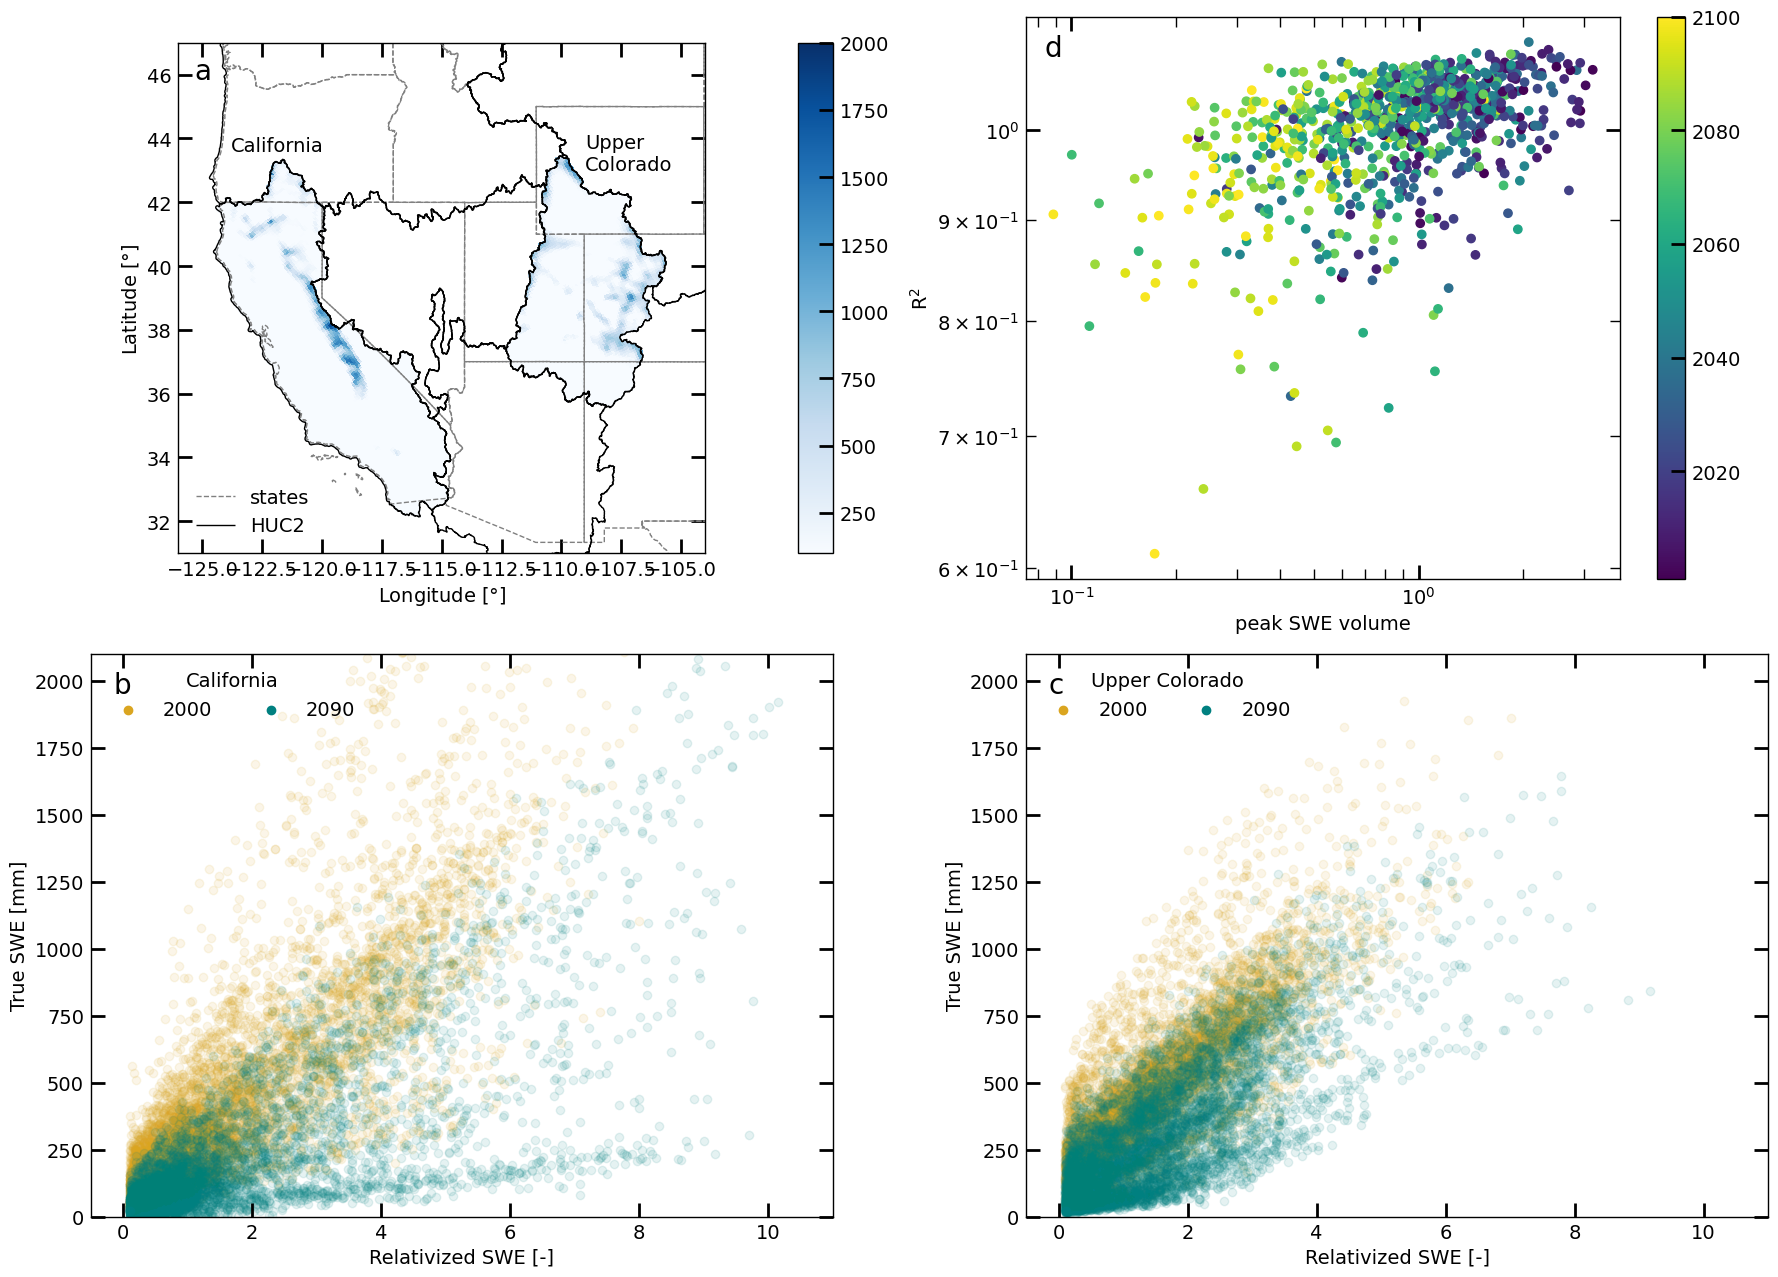

In [9]:

minval = 10
bs = [4, 1]  # California, Colorado
labels = ['California', 'Upper Colorado']
ycol = ['goldenrod', 'teal']
fcol = ['gray', 'black']


mosaic = """AADD
            BBCC
            """

letters = ['B', 'C']
fig = plt.figure(figsize=(18, 13), tight_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
map_ax = ax_dict['A']

for j, b in enumerate(bs):
    mydata = all_SDVs.sel(basin = b)
    cb = map_ax.pcolormesh(lon, lat, mydata.sel(year=y1).mean(dim='gcm')['swe'], cmap='Blues', vmin=100, vmax=2000)

divider = make_axes_locatable(map_ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)

states.boundary.plot(ax=map_ax, linewidth=1, linestyle='--', color='gray', label='states')
hucs_plot.boundary.plot(ax=map_ax, linewidth=1, label='HUC2')


for i, letter in enumerate(letters):
    mydata = all_SDVs.sel(basin = bs[i])
    ax = ax_dict[letter]
    for k, yr in enumerate([y1, y2]):
        allr2s = []
        ydata = mydata.sel(year=slice(yr - 21, yr - 1)).mean(dim='year')
        swedata = mydata.sel(year = yr)
        ydata = ydata.where(ydata['relativized_swe'] > 0.1)
        swedata = swedata.where(ydata['relativized_swe'] > 0.1)
        for gcm in ydata.gcm:
            swe = swedata['swe'].sel(gcm=gcm)
            ssv = ydata['relativized_swe'].sel(gcm=gcm)
            x, y, r2 = get_linfit(ssv, swe)
            allr2s.append(r2)
            ax.scatter(ssv, swe, color=ycol[k], alpha=0.1)
            #ax.plot(x, y, color=fcol[k], label=r'R$^{2}$=' + "%.2f" % r2) 
        print(np.nanmean(np.array(allr2s)))
        ax.scatter(np.nanpercentile(ssv, 1), np.nanpercentile(swe, 1), color=ycol[k], alpha=1, label=yr) # extra just for the plot plotting
    ax.set_ylim((0, 2100))
    ax.set_xlim((-0.5, 11))
    #ax.text(0.1,0.95,labels[i],transform = ax.transAxes)
    leg = ax.legend(ncol=2, loc='upper left')
    leg.set_title(labels[i])
    ax.set_ylabel('True SWE [mm]')
    ax.set_xlabel('Relativized SWE [-]')
    
ax = ax_dict['D']
for i in range(9):
    snows = all_snows[i] / np.nanmean(all_snows[i])
    r2s = all_r2s[i] / np.nanmean(all_r2s[i])
    yrs = all_yrs[i]
    cb = ax.scatter(snows, r2s, c=yrs)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('peak SWE volume')
ax.set_ylabel(r'R$^2$')
plt.colorbar(cb)

map_ax.text(-123.8, 43.6, 'California')
map_ax.text(-109, 43, 'Upper\nColorado')
map_ax.legend(loc='lower left')
map_ax.set_ylabel(r'Latitude [$\degree$]')
map_ax.set_xlabel(r'Longitude [$\degree$]')
map_ax.set_xlim((-126, -104))
map_ax.set_ylim((31, 47))

LETTERS = True
if LETTERS:
    for key in ax_dict.keys():
        myax = ax_dict[key]
        myax.text(0.03,0.93, key.lower(), fontsize = 20, transform = myax.transAxes)

fig.savefig(f'{basedir}/figures/ext_pattern.png')

plt.show()


In [10]:
## print some stats

for i,b in enumerate(bs):
    mydata = all_SDVs.sel(basin = b)['swe']
    print(labels[i])
    y1s = mydata.sel(year=y1).mean(dim='gcm').sum().values.flatten()[0]
    y2s = mydata.sel(year=y2).mean(dim='gcm').sum().values.flatten()[0]
    print(f'{yrs[0]}: {y1s:.2f} mm\n{yrs[1]}: {y2s:.2f} mm\ndiff: {y1s - y2s:.2f} mm\npct: {100 * (y1s - y2s) / y1s:.2f}%')

        

California
2001: 412606.12 mm
2002: 158651.56 mm
diff: 253954.56 mm
pct: 61.55%
Upper Colorado
2001: 497079.81 mm
2002: 257022.80 mm
diff: 240057.02 mm
pct: 48.29%
